# Reproduction of Fig. S1

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.collections import PatchCollection
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.ticker import MultipleLocator
from pyscripts.config import path2
from pyscripts.datasets import Metadata
from pyscripts.visualization import ColorUniversalDesign as CUD

metadata = Metadata()

In [2]:
nts_summary = pd.read_pickle(path2.data/'kmer'/'nts_summary.pkl.bz2')
GC = nts_summary.T.eval('(G+C)/(G+C+A+T)*100')

In [3]:
iupred_summary = pd.read_pickle(
    path2.data/'iupred2a'/'summary.pkl.bz2'
).swaplevel(0,1,axis=1).swaplevel(1,2,axis=1).sort_index(axis=1)

In [4]:
topidp_summary = pd.read_pickle(path2.data/'topidp'/'summary.pkl.bz2')

In [5]:
gtdbrep2refseq = metadata.acc.set_index('gtdbrep')['refseq']
refseq2gtdbrep = metadata.acc.set_index('refseq')['gtdbrep']
acc_ordered = pd.DataFrame([
    (refseq_acc, gtdb_acc)
    for gtdb_acc in metadata.bac120_tree.iter_leaf_names() 
    if (refseq_acc := gtdbrep2refseq.get(gtdb_acc)) is not None
], columns=['refseq', 'gtdbrep'])
gtdb_taxonomy = metadata.taxrank_inuse.loc[acc_ordered['gtdbrep']]

phylum_counts = gtdb_taxonomy['phylum'].value_counts()[gtdb_taxonomy['phylum'].unique()]
top_idx = phylum_counts[phylum_counts >= 40].sort_values(ascending=False).index
phylum_masked = gtdb_taxonomy['phylum'].where(gtdb_taxonomy['phylum'].isin(top_idx), '(others)')
phylum_color = (phylum_counts.rank(method='first', ascending=False).astype(int)-1).apply(CUD.OkabeIto_cmap)

In [19]:
plt.rcParams

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.f

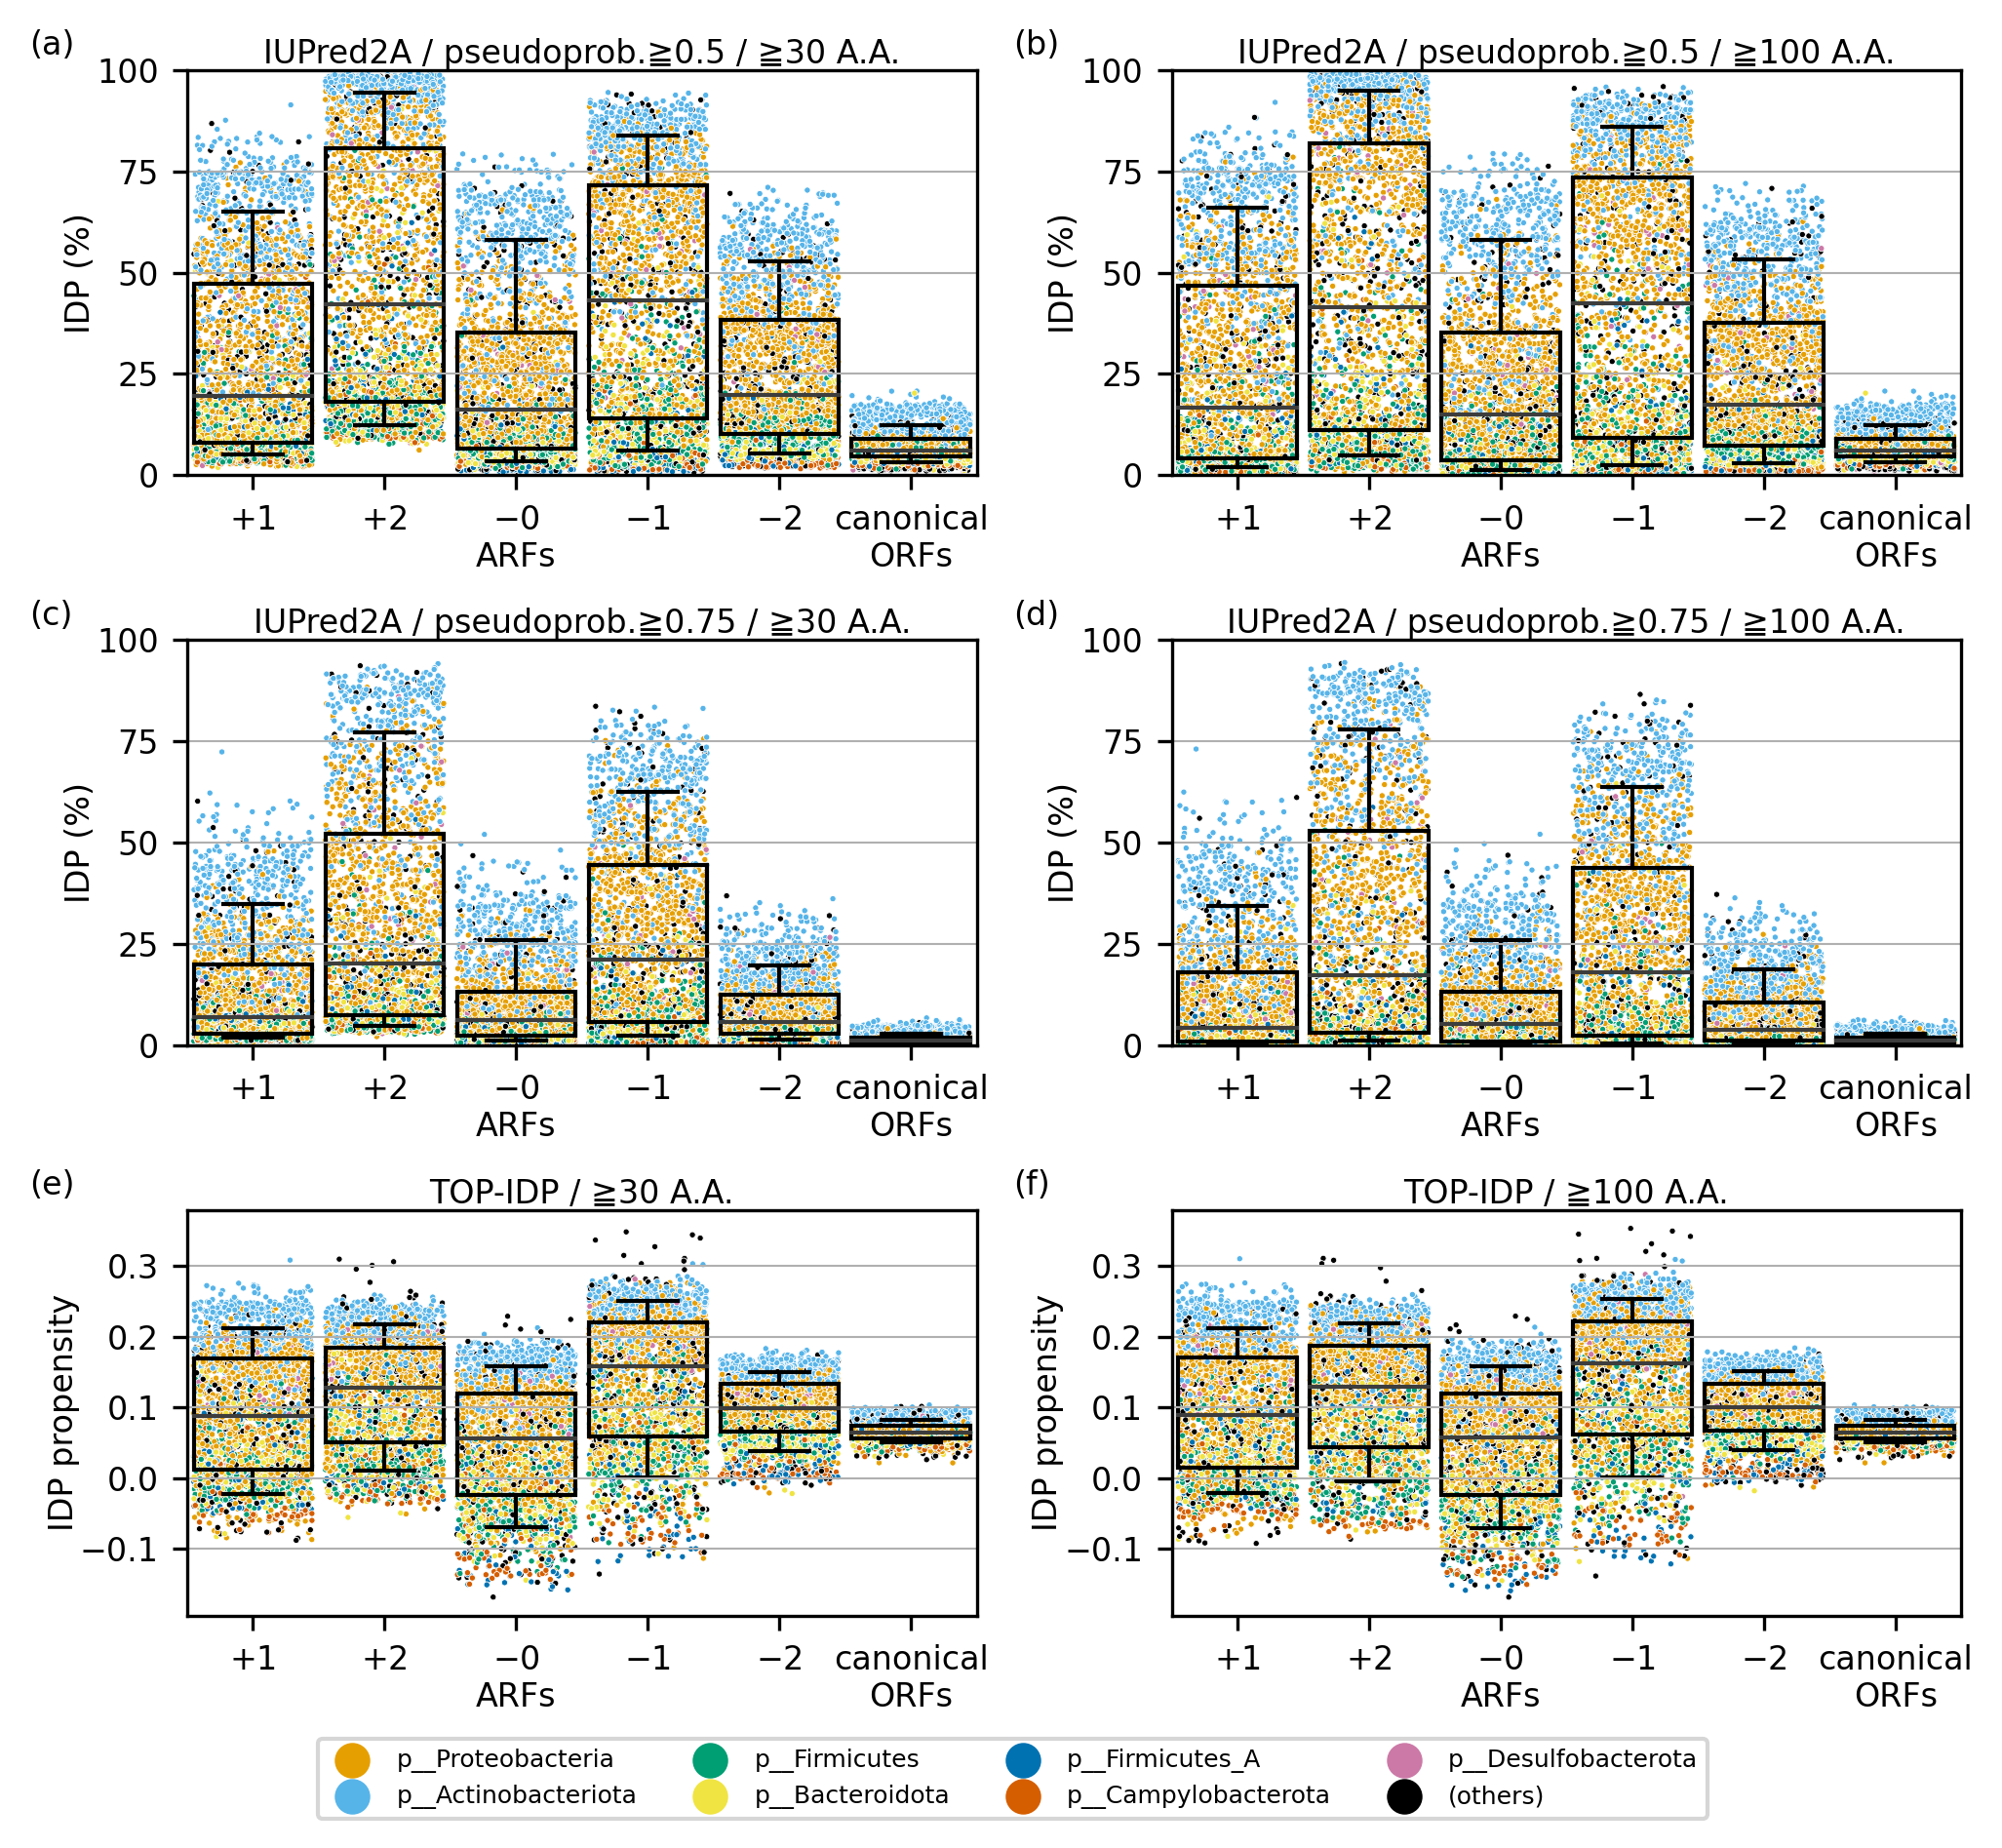

In [29]:
mm = 1 / 25.4
fr_mapping = {0: 'undet', 1: 'CDS', 2: '+1',  4: '+2',  8: '-0', 16: '-1', 32: '-2'}
    
with plt.rc_context({'font.size': 8, 'axes.titlesize': 8, 'grid.linewidth': 0.5}):
    fig, axes = plt.subplots(3, 2, figsize=(174*mm, 160*mm), dpi=300, sharey='row')
    
    # IUPred related
    for ax, p, (len_thresh, prob_thresh) in zip(axes[0:2,0:2].flatten(), 'abcd', [(30, 0.5), (100, 0.5), (30, 0.75), (100, 0.75)]):
        idp_ratio = iupred_summary[len_thresh,prob_thresh] / iupred_summary[len_thresh,0.0].fillna(0) * 100
        pltdata = idp_ratio.rename_axis(index='frame', columns='gcf').rename(index=fr_mapping).stack().rename('IDP').reset_index()
        pltdata = pltdata.assign(phylum=pltdata['gcf'].map(refseq2gtdbrep).map(phylum_masked))

        sns.boxplot(
            x='frame', y='IDP', data=pltdata, order=['+1', '+2', '-0', '-1', '-2', 'CDS'], width=0.9,
            linewidth=1, ax=ax, capprops={'color':'k', 'zorder': 1}, whiskerprops={'color':'k', 'zorder': 1}, boxprops={'facecolor':'none', 'edgecolor':'k', 'zorder': 1}, whis=[10, 90], fliersize=0
        )
        sns.stripplot(
            x='frame', y='IDP', data=pltdata, order=['+1', '+2', '-0', '-1', '-2', 'CDS'],
            hue='phylum', hue_order=[*top_idx, '(others)'], palette=CUD.OkabeIto_cpal,
            jitter=0.45, s=1.5, ec='w', linewidth=0.2, ax=ax, zorder=0
        )
    
        ax.legend().remove()
        ax.set_xlabel(None)
        ax.set_ylim(0, 100),
        ax.set_ylabel('IDP (%)', labelpad=0.05)
        ax.set_title(f'IUPred2A / pseudoprob.≧{prob_thresh} / ≧{len_thresh} A.A.', pad=0.05)
        ax.set(
            xticks=[0, 1, 2, 3, 4, 5],
            xticklabels=['$+1$', '$+2$', '$-0$\nARFs', '$-1$', '$-2$', 'canonical\nORFs']
        )
        ax.yaxis.grid()
        ax.text(-0.2, 1.1, f'({p})', va='top', ha='left', transform=ax.transAxes)
    # TOP-IDP related
    for ax, p, len_thresh in zip(axes[2], 'ef', (30, 100)):
        pltdata = topidp_summary.swaplevel(0, 1, axis=1)[len_thresh].rename(index=fr_mapping).stack().rename_axis(['frame','gcf']).rename('IDP').reset_index()
        pltdata = pltdata.assign(phylum=pltdata['gcf'].map(refseq2gtdbrep).map(phylum_masked))

        sns.boxplot(
            x='frame', y='IDP', data=pltdata, order=['+1', '+2', '-0', '-1', '-2', 'CDS'], width=0.9,
            linewidth=1, ax=ax, capprops={'color':'k', 'zorder': 1}, whiskerprops={'color':'k', 'zorder': 1}, boxprops={'facecolor':'none', 'edgecolor':'k', 'zorder': 1}, whis=[10, 90], fliersize=0
        )
        sns.stripplot(
            x='frame', y='IDP', data=pltdata, order=['+1', '+2', '-0', '-1', '-2', 'CDS'],
            hue='phylum', hue_order=[*top_idx, '(others)'], palette=CUD.OkabeIto_cpal,
            jitter=0.45, s=1.5, ec='w', linewidth=0.2, ax=ax, zorder=0
        )
        ax.legend().remove()
        ax.set_ylabel('IDP propensity', labelpad=0.05)
        ax.set_title(f'TOP-IDP / ≧{len_thresh} A.A.', pad=0.05)
        ax.set(
            xlabel=None,
            xticks=[0, 1, 2, 3, 4, 5],
            xticklabels=['$+1$', '$+2$', '$-0$\nARFs', '$-1$', '$-2$', 'canonical\nORFs']
        )
        ax.yaxis.grid()
        ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
        ax.text(-0.2, 1.1, f'({p})', va='top', ha='left', transform=ax.transAxes)
    else:
        # legend
        han, lab = ax.get_legend_handles_labels()
        fig.legend(han, lab, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.06), fontsize=6)
    
    # common settings
    for ax in axes.flatten():
        ax.yaxis.set_tick_params(left=True, labelleft=True)
        
    #fig.text(0, 0.99, '(a)', va='top', ha='left')
    #fig.text(0.49, 0.99, '(b)', va='top', ha='left')
    #fig.text(0, 0.67, '(c)', va='top', ha='left')
    #fig.text(0.49, 0.67, '(d)', va='top', ha='left')
    #fig.text(0, 0.35, '(e)', va='top', ha='left')
    #fig.text(0.49, 0.35, '(f)', va='top', ha='left')
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.12)
    fig.savefig('./Figs/FigS1.pdf')
    fig.patch.set_facecolor('w')
    fig.savefig('./Figs/FigS1.tif')